In [1]:
library(glmnet)
library(ggplot2)
library(cowplot)
library(foreach)
library(doMC)
library(ComplexHeatmap)

library(Seurat)
library(useful)
library(harmony)

library(RColorBrewer)
library(Scillus)
library(ggrepel)
library(stringr)
library(dplyr)

set.seed(1234)

Loading required package: Matrix

Loaded glmnet 4.1-2

Loading required package: iterators

Loading required package: parallel

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Attaching SeuratObject

Attaching sp

Loading required package: Rcpp


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from

### For the cell of origin analysis, we adapt the approach from Young et al, 2018: https://github.com/constantAmateur/scKidneyTumors/tree/master

### 1. Select features for training by running DE between all non-contaminating normal kidney clusters. Due to cell numbers this is a time-consuming step that we recommend running non-interactively. This step is provided as the following R script: NormalKidney_COI_FeatureSelection_Final.R

### 2. Prepare normal kidney and tumor data objects, then train models for cell type similarity inference. This step should also be run non-interactively. We provide the following Rscript: TrainModel_NormalKidney_Final.R

### 3. Use trained models to predict similarity between tumor and normal clusters

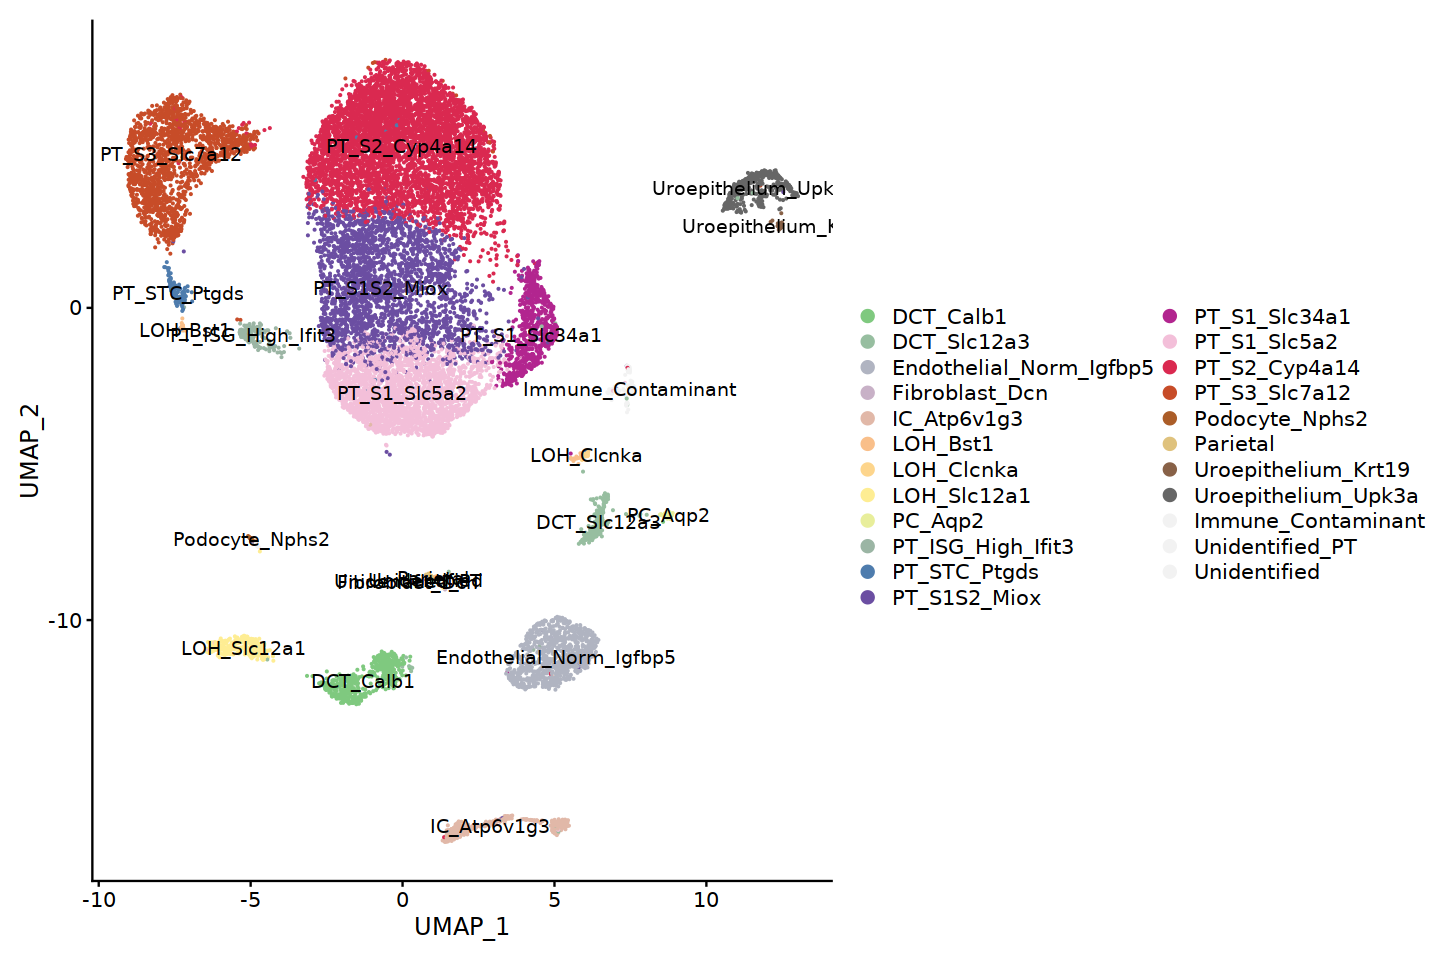

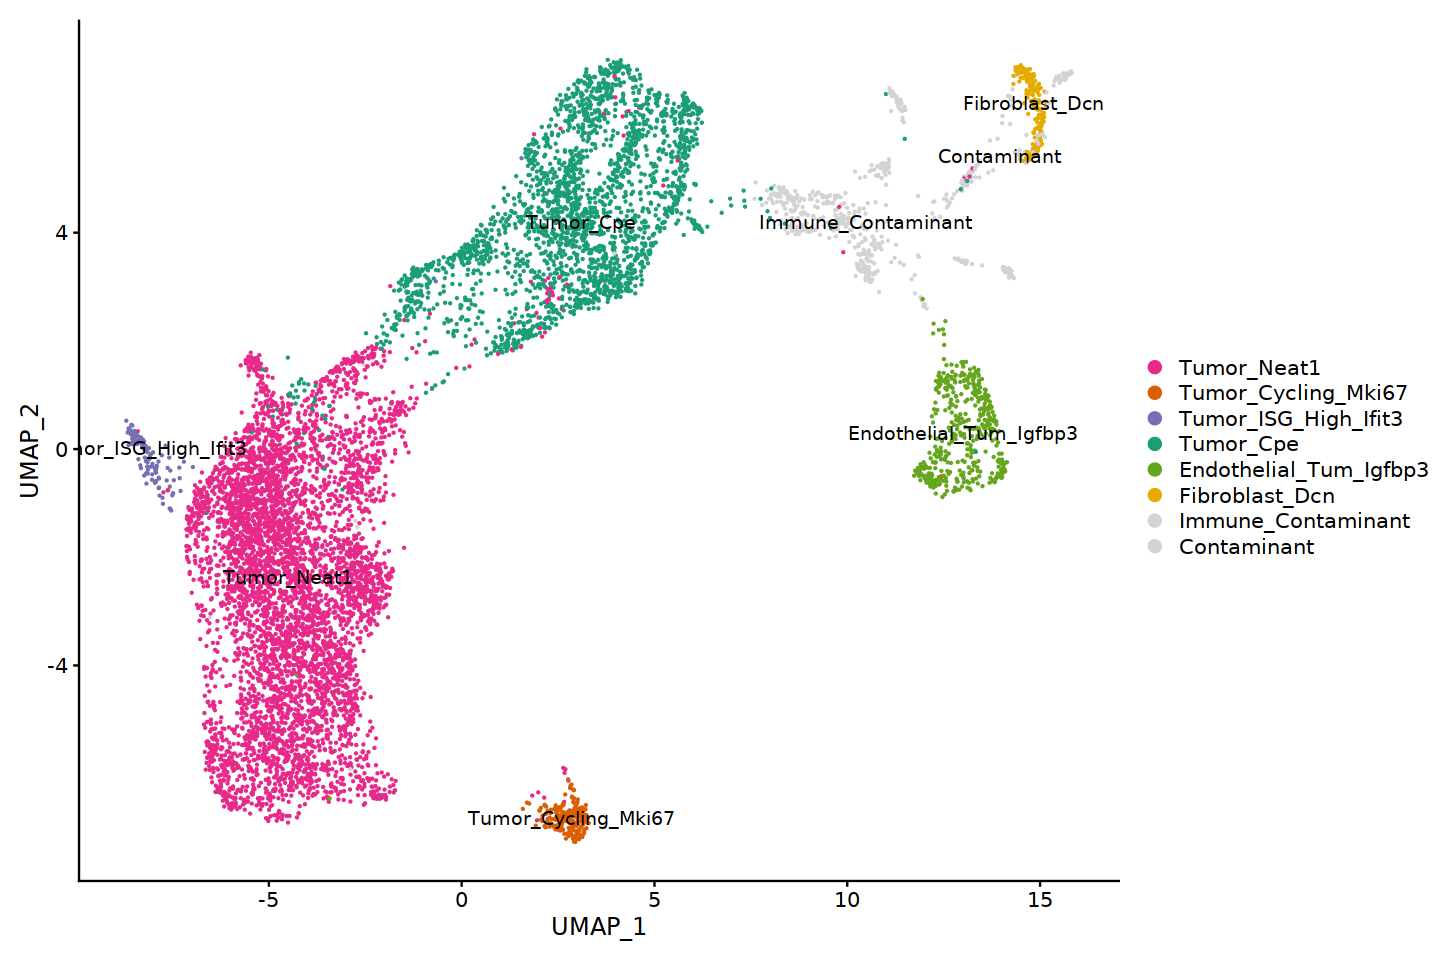

In [2]:
seur_n = readRDS(file = "Manuscript_Objects/NonImmune_NormalKidney_AmbFilt_SeuratObject_Final.RDS")
n_cols = readRDS(file = "Manuscript_Objects/NormalKidney_NonImmune_Colors_Final.RDS")

options(repr.plot.width=12, repr.plot.height=8)
DimPlot(seur_n, label = T, cols = n_cols[levels(Idents(seur_n))])

seur_t = readRDS(file = "Manuscript_Objects/NonImmune_Tumor_AmbFilt_SeuratObject.RDS")
t_cols = readRDS(file = "Manuscript_Objects/Tumor_NonImmune_Colors.RDS")

options(repr.plot.width=12, repr.plot.height=8)
DimPlot(seur_t, label = T, cols = t_cols)

In [3]:
seur_n

An object of class Seurat 
23871 features across 16665 samples within 1 assay 
Active assay: RNA (23871 features, 3000 variable features)
 3 dimensional reductions calculated: pca, umap, harmony

In [4]:
n_omits = c("Immune_Contaminant","Unidentified","Unidentified_PT")
seur_n = subset(seur_n, idents = n_omits, invert = T)

t_omits = c("Immune_Contaminant","Contaminant")
seur_t = subset(seur_t, idents = t_omits, invert = T)
table(Idents(seur_t))
seur_t$Annot_Granular = droplevels(seur_t$Annot_Granular)
table(seur_t$Annot_Granular)

meta = seur_t@meta.data
meta = mutate(meta, Annot_Test = ifelse(Annot_Granular %in% c("Tumor_Neat1","Tumor_Cpe","Tumor_Cycling_Mki67","Tumor_ISG_High_Ifit3"),paste(Annot_Granular, Sample, sep = "."),paste(Annot_Granular)))
table(meta$Annot_Test)

seur_t$Annot_Test = meta$Annot_Test
Idents(seur_t) = seur_t$Annot_Test


           Tumor_Neat1    Tumor_Cycling_Mki67   Tumor_ISG_High_Ifit3 
                  5208                    219                    119 
             Tumor_Cpe Endothelial_Tum_Igfbp3         Fibroblast_Dcn 
                  2398                    468                    189 


           Tumor_Neat1    Tumor_Cycling_Mki67   Tumor_ISG_High_Ifit3 
                  5208                    219                    119 
             Tumor_Cpe Endothelial_Tum_Igfbp3         Fibroblast_Dcn 
                  2398                    468                    189 


           Endothelial_Tum_Igfbp3                    Fibroblast_Dcn 
                              468                               189 
            Tumor_Cpe.11_VX5256_T               Tumor_Cpe.3_BB453_T 
                              206                               941 
           Tumor_Cpe.6_BB452_KL_T               Tumor_Cpe.9_VX516_T 
                              599                               652 
    Tumor_Cycling_Mki67.3_BB453_T  Tumor_Cycling_Mki67.6_BB452_KL_T 
                               80                                 8 
    Tumor_Cycling_Mki67.9_VX516_T  Tumor_ISG_High_Ifit3.11_VX5256_T 
                              131                                 1 
   Tumor_ISG_High_Ifit3.3_BB453_T Tumor_ISG_High_Ifit3.6_BB452_KL_T 
                               83                                 4 
   Tumor_ISG_High_Ifit3.9_VX516_T           Tumor_Neat1.11_VX5256_T 
                               31                                75 
            Tumor_Neat1.3_BB453_T

In [5]:
normal_clusters = as.character(unique(Idents(seur_n)))
tumor_clusters = as.character(unique(Idents(seur_t)))

normal_clusters
tumor_clusters

length(normal_clusters)
length(tumor_clusters)

[1] "PT_S3_Slc7a12"           "Uroepithelium_Upk3a"    
 [3] "PT_S2_Cyp4a14"           "PT_S1S2_Miox"           
 [5] "PT_S1_Slc5a2"            "Uroepithelium_Krt19"    
 [7] "IC_Atp6v1g3"             "PT_ISG_High_Ifit3"      
 [9] "DCT_Calb1"               "PT_STC_Ptgds"           
[11] "LOH_Slc12a1"             "PC_Aqp2"                
[13] "PT_S1_Slc34a1"           "Fibroblast_Dcn"         
[15] "DCT_Slc12a3"             "LOH_Clcnka"             
[17] "LOH_Bst1"                "Endothelial_Norm_Igfbp5"
[19] "Parietal"                "Podocyte_Nphs2"

[1] "Tumor_Cpe.11_VX5256_T"             "Fibroblast_Dcn"                   
 [3] "Tumor_Neat1.11_VX5256_T"           "Endothelial_Tum_Igfbp3"           
 [5] "Tumor_ISG_High_Ifit3.11_VX5256_T"  "Tumor_Neat1.3_BB453_T"            
 [7] "Tumor_Cpe.3_BB453_T"               "Tumor_Cycling_Mki67.3_BB453_T"    
 [9] "Tumor_ISG_High_Ifit3.3_BB453_T"    "Tumor_Cpe.6_BB452_KL_T"           
[11] "Tumor_Neat1.6_BB452_KL_T"          "Tumor_Cycling_Mki67.6_BB452_KL_T" 
[13] "Tumor_ISG_High_Ifit3.6_BB452_KL_T" "Tumor_Cpe.9_VX516_T"              
[15] "Tumor_Neat1.9_VX516_T"             "Tumor_Cycling_Mki67.9_VX516_T"    
[17] "Tumor_ISG_High_Ifit3.9_VX516_T"

[1] 20

[1] 17

### There are few normal cell types where convergence for 2th lambda value was not reached after 100,000 iterations. We move these identities to the end and order the rest for ease of visualization 

In [6]:
nopred = c("Uroepithelium_Krt19","PC_Aqp2","Fibroblast_Dcn","LOH_Clcnka","LOH_Bst1","Podocyte_Nphs2","Parietal")
normal_clusters_ordered = c("PT_S1_Slc34a1","PT_S1_Slc5a2","PT_S1S2_Miox","PT_S2_Cyp4a14","PT_S3_Slc7a12","PT_STC_Ptgds","PT_ISG_High_Ifit3","LOH_Slc12a1","DCT_Calb1","DCT_Slc12a3","IC_Atp6v1g3","Endothelial_Norm_Igfbp5","Uroepithelium_Upk3a",nopred)
length(normal_clusters_ordered)

tumor_clusters_ordered = c("Tumor_Neat1.11_VX5256_T","Tumor_ISG_High_Ifit3.11_VX5256_T","Tumor_Cpe.11_VX5256_T","Tumor_Neat1.3_BB453_T","Tumor_Cycling_Mki67.3_BB453_T","Tumor_ISG_High_Ifit3.3_BB453_T","Tumor_Cpe.3_BB453_T","Tumor_Neat1.6_BB452_KL_T","Tumor_Cycling_Mki67.6_BB452_KL_T","Tumor_ISG_High_Ifit3.6_BB452_KL_T","Tumor_Cpe.6_BB452_KL_T","Tumor_Neat1.9_VX516_T","Tumor_Cycling_Mki67.9_VX516_T","Tumor_ISG_High_Ifit3.9_VX516_T","Tumor_Cpe.9_VX516_T","Endothelial_Tum_Igfbp3","Fibroblast_Dcn")
length(tumor_clusters_ordered)

[1] 20

[1] 17

In [7]:
rtoc = readRDS("Manuscript_Objects/rtoc_NormalKidney_Tumor_Final.RDS")

In [8]:
fitNormalClusters = readRDS("Manuscript_Objects/TrainedModels_NormalKidney_SelectedFeatures_Final.RDS")

In [9]:
testDat = list(toc = seur_t@assays$RNA@data, mDat = seur_t@meta.data)

dat = Seurat::LogNormalize(rtoc[,colnames(testDat$toc)])
#dat = rbind(dat, sex)
dat = t(dat)

fits = fitNormalClusters

preds = list()
for(mark in names(fits)){
  message(sprintf("Predicting probabilities for cluster %s",mark))
  preds[[mark]] = predict(fits[[mark]],newx=dat[,rownames(fits[[mark]]$glmnet.fit$beta)],s='lambda.1se',newoffset=rep(0,nrow(dat)))
  if(all(preds[[mark]]==0))
    next}

pp = do.call(cbind,preds)
colnames(pp) = names(preds)

clusterPreds = apply(pp,2,function(e) sapply(split(e,testDat$mDat$Annot_Test),mean))
clusterPreds = (1+exp(-clusterPreds))**-1                    

gg = Heatmap(clusterPreds,
             name='Predicted\nSimilarity',
             column_title='Normal Clusters',
             row_title='Tumour Clusters',
             show_row_names=TRUE,
             #split=row_splitter,
             row_order=tumor_clusters_ordered,
             column_order=normal_clusters_ordered,
             cluster_rows=FALSE,
             cluster_columns=FALSE
             )            

Predicting probabilities for cluster Parietal

Predicting probabilities for cluster Podocyte_Nphs2

Predicting probabilities for cluster LOH_Clcnka

Predicting probabilities for cluster Fibroblast_Dcn

Predicting probabilities for cluster Uroepithelium_Krt19

Predicting probabilities for cluster LOH_Bst1

Predicting probabilities for cluster PC_Aqp2

Predicting probabilities for cluster PT_STC_Ptgds

Predicting probabilities for cluster PT_ISG_High_Ifit3

Predicting probabilities for cluster DCT_Slc12a3

Predicting probabilities for cluster LOH_Slc12a1

Predicting probabilities for cluster Uroepithelium_Upk3a

Predicting probabilities for cluster IC_Atp6v1g3

Predicting probabilities for cluster DCT_Calb1

Predicting probabilities for cluster PT_S1_Slc34a1

Predicting probabilities for cluster Endothelial_Norm_Igfbp5

Predicting probabilities for cluster PT_S3_Slc7a12

Predicting probabilities for cluster PT_S1S2_Miox

Predicting probabilities for cluster PT_S1_Slc5a2

Predicting proba

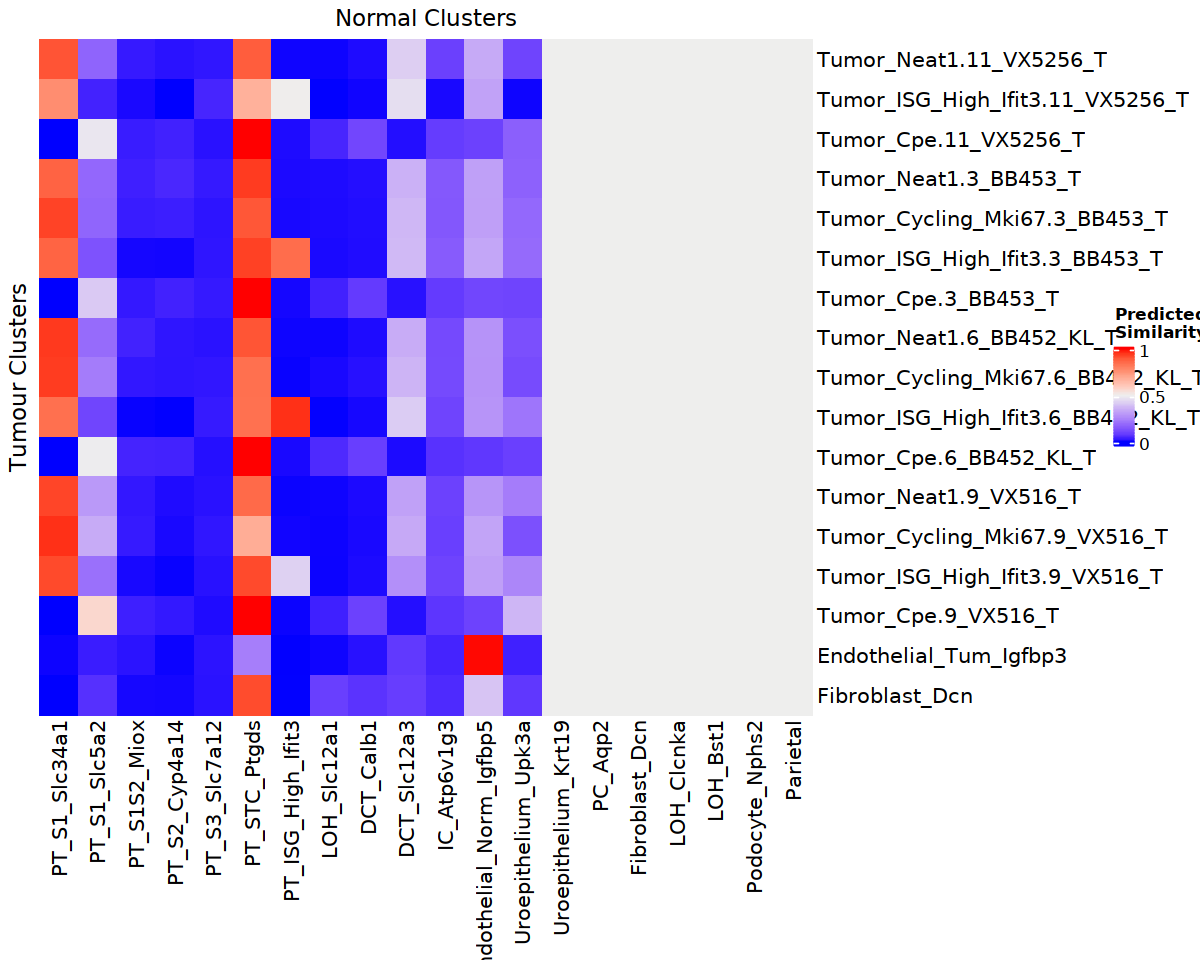

In [10]:
options(repr.plot.width=10, repr.plot.height=8)
gg

In [14]:
pdf("Manuscript_Figures/Young_Similarity_Final_032224_RdBu.pdf", width = 10, height = 8)

gg = Heatmap(clusterPreds,
             name='Predicted\nSimilarity',
             column_title='Normal Clusters',
             row_title='Tumour Clusters',
             show_row_names=TRUE,
             #split=row_splitter,
             row_order=tumor_clusters_ordered,
             column_order=normal_clusters_ordered,
             cluster_rows=FALSE,
             cluster_columns=FALSE,
             col = rev(colorRampPalette(brewer.pal(5, "RdBu"))(100))
             )            
options(repr.plot.width=10, repr.plot.height=8)

gg

dev.off()

png 
  2

In [11]:
orderedPreds = t(clusterPreds[tumor_clusters_ordered, normal_clusters_ordered])
head(orderedPreds)

,Tumor_Neat1.11_VX5256_T,Tumor_ISG_High_Ifit3.11_VX5256_T,Tumor_Cpe.11_VX5256_T,Tumor_Neat1.3_BB453_T,Tumor_Cycling_Mki67.3_BB453_T,Tumor_ISG_High_Ifit3.3_BB453_T,Tumor_Cpe.3_BB453_T,Tumor_Neat1.6_BB452_KL_T,Tumor_Cycling_Mki67.6_BB452_KL_T,Tumor_ISG_High_Ifit3.6_BB452_KL_T,Tumor_Cpe.6_BB452_KL_T,Tumor_Neat1.9_VX516_T,Tumor_Cycling_Mki67.9_VX516_T,Tumor_ISG_High_Ifit3.9_VX516_T,Tumor_Cpe.9_VX516_T,Endothelial_Tum_Igfbp3,Fibroblast_Dcn
PT_S1_Slc34a1,0.90462543,7.709055e-01,1.466617e-05,0.87295480,0.93684587,0.872381889,1.818384e-05,0.95206413,0.94706020,0.8453463444,8.327350e-06,0.93220633,0.964038465,0.924581348,1.211656e-05,0.002767686,1.992712e-05
PT_S1_Slc5a2,0.17499661,3.746831e-02,4.800589e-01,0.18350386,0.17717155,0.133626521,4.134995e-01,0.19123325,0.23143854,0.1052523840,4.936496e-01,0.29969049,0.342950680,0.203095784,5.660569e-01,0.028400885,6.174450e-02
PT_S1S2_Miox,0.02497638,6.879139e-03,2.792136e-02,0.03342328,0.02805742,0.005278728,2.363038e-02,0.03700885,0.02195402,0.0016081937,3.985001e-02,0.02219904,0.025033749,0.006460167,3.236607e-02,0.016771270,5.651140e-03
PT_S2_Cyp4a14,0.01580657,7.327557e-05,3.598739e-02,0.04617152,0.03097076,0.004365433,3.632527e-02,0.01969957,0.01878743,0.0003745315,3.750296e-02,0.00941029,0.006554355,0.001989546,2.282617e-02,0.002602385,4.845214e-03
PT_S3_Slc7a12,0.02023280,4.229896e-02,1.499011e-02,0.02419150,0.01784541,0.019053993,2.416196e-02,0.01599185,0.02054039,0.0253446884,1.271355e-02,0.01489783,0.020136668,0.014409423,9.265830e-03,0.017435368,1.603173e-02
PT_STC_Ptgds,0.88595257,6.743633e-01,9.997074e-01,0.94871888,0.89896787,0.939580705,9.997815e-01,0.90379405,0.84442161,0.8420971359,9.998536e-01,0.85823795,0.685151047,0.923452118,9.998240e-01,0.237151762,9.212221e-01


In [12]:
write.table(orderedPreds, file = "Manuscript_Figures/Ordered_Similarity_Predictions_Final.txt", sep = '\t',quote = F, col.names = NA)

### Main figure heatmap visualization generated via GENE-E using this ordered similarity predictions file